In [1]:
# 파이썬 ≥3.5 필수
import sys

assert sys.version_info >= (3, 5)

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 사이킷런 ≥0.20 필수
import sklearn

assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras

assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
from pathlib import Path

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# data_for_lstm.csv 파일 존재 확인
data_path = os.path.join(PROJECT_ROOT_DIR, "RX_Rate.csv")
if not os.path.isfile(data_path):
    print("data_for_lstm.csv 파일이 존재하지 않습니다.")


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


import pandas as pd

data_for_lstm.csv 파일이 존재하지 않습니다.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/RX_Rate.csv')

In [4]:
df.head()

,Unnamed: 0,Date,회차,등록시간,매매기준율,이전대비,송금보내실 때,송금받으실 때,현찰사실 때,현찰파실 때,USD환산율
0,0,20161230,1,08:37:50,"1,208.50",-,"1,219.90","1,197.10","1,229.64","1,187.36",1.0
1,1,20161230,2,08:40:58,"1,208.50",-,"1,219.90","1,197.10","1,229.64","1,187.36",1.0
2,2,20161230,3,08:43:31,"1,208.50",-,"1,219.90","1,197.10","1,229.64","1,187.36",1.0
3,3,20161230,4,08:52:44,"1,208.50",-,"1,219.90","1,197.10","1,229.64","1,187.36",1.0
4,4,20161230,5,08:58:11,"1,208.00",▼0.50,"1,219.40","1,196.60","1,229.14","1,186.86",1.0


In [5]:
df['매매기준율'] = df['매매기준율'].str.replace(',', '').astype(float)
baseRate = df['매매기준율'].values
baseRate

array([1208.5, 1208.5, 1208.5, ..., 1309.5, 1308. , 1309.5])

In [6]:
plt.figure(figsize=(200,100))
plt.plot(baseRate)
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# # Normalize the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
baseRate = scaler.fit_transform(baseRate.reshape(-1, 1))

# Split the data into sequences of length 50
sequence_length = 50

sequences = []
for i in range(sequence_length, len(baseRate)):
    sequences.append(baseRate[i - sequence_length:i + 1])

# Convert the list of sequences to a numpy array
sequences = np.array(sequences)

# Split the sequences into input (X) and output (y)
X = sequences[:, :-1]
y = sequences[:, -1]

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input data to be suitable for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((139539, 50, 1), (34885, 50, 1), (139539, 1), (34885, 1))

In [8]:
# Assume that X_train is your preprocessed (normalized) data
# We have to reshape it back to 2D before inverse transform
X_train_2D = X_train.reshape(-1, 1)

# Use the "scaler" object to inverse transform the data
X_train_raw = scaler.inverse_transform(X_train_2D)

# If you want to reshape it back to the original shape:
X_train_raw = X_train_raw.reshape(X_train.shape)

X_train_raw[0][:5]  # Show the first 5 sequences in raw form

array([[1226.8],
       [1226.8],
       [1226.8],
       [1227. ],
       [1226.7]])

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


# Define the LSTM model
model = tf.keras.Sequential([
        LSTM(100, input_shape=(sequence_length, 1)),
        Dense(1)
])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Compile the model
model.compile(loss='mean_squared_error', optimizer='Adam')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=400, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
349/349 [==============================] - 10s 8ms/step - loss: 0.0015 - val_loss: 1.1754e-05
Epoch 2/50
349/349 [==============================] - 2s 7ms/step - loss: 1.1712e-05 - val_loss: 1.1424e-05
Epoch 3/50
349/349 [==============================] - 2s 7ms/step - loss: 1.1356e-05 - val_loss: 1.1008e-05
Epoch 4/50
349/349 [==============================] - 2s 7ms/step - loss: 1.1004e-05 - val_loss: 1.0868e-05
Epoch 5/50
349/349 [==============================] - 2s 7ms/step - loss: 1.0609e-05 - val_loss: 1.0144e-05
Epoch 6/50
349/349 [==============================] - 2s 7ms/step - loss: 1.0311e-05 - val_loss: 9.7962e-06
Epoch 7/50
349/349 [==============================] - 2s 7ms/step - loss: 9.7611e-06 - val_loss: 9.3512e-06
Epoch 8/50
349/349 [==============================] - 2s 7ms/step - loss: 9.7010e-06 - val_loss: 9.0441e-06
Epoch 9/50
349/349 [==============================] - 2s 7ms/step - loss: 9.4313e-06 - val_loss: 9.2712e-06
Epoch 10/50
349/349 [==========

In [10]:
model.save('FX-lstm.h5')
# model.save('/content/drive/MyDrive/FX-lstm.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


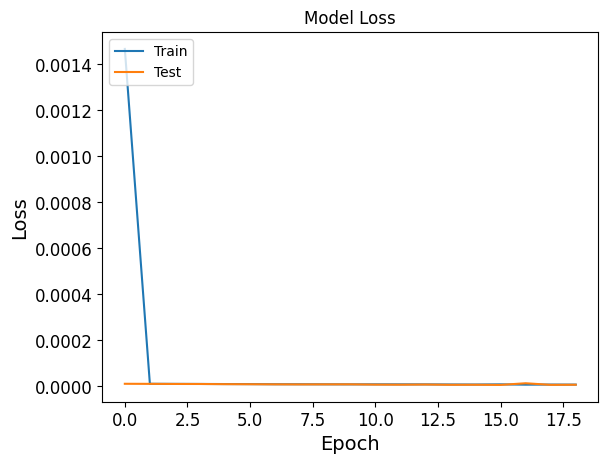

In [11]:
# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
predictions = model.predict(X_test)

# 예측 결과 출력
for i, prediction in enumerate(predictions[:10]):
    print(f"Input: {X_test[i]}, Target: {y_test[i]}, Predicted: {prediction}")

mse = np.mean((predictions - y_test) ** 2)
print(f"Mean Squared Error: {mse}")

1091/1091 [==============================] - 3s 2ms/step
Input: [[0.20997442]
 [0.21023018]
 [0.21023018]
 [0.21048593]
 [0.21074169]
 [0.21099744]
 [0.21150895]
 [0.21176471]
 [0.21099744]
 [0.21099744]
 [0.2112532 ]
 [0.21074169]
 [0.21074169]
 [0.21048593]
 [0.21074169]
 [0.21048593]
 [0.21023018]
 [0.20997442]
 [0.21023018]
 [0.2084399 ]
 [0.2084399 ]
 [0.20895141]
 [0.20920716]
 [0.20920716]
 [0.20946292]
 [0.20920716]
 [0.20946292]
 [0.20920716]
 [0.20920716]
 [0.20869565]
 [0.20869565]
 [0.20920716]
 [0.20895141]
 [0.20869565]
 [0.20895141]
 [0.20920716]
 [0.20869565]
 [0.2084399 ]
 [0.20869565]
 [0.2084399 ]
 [0.20792839]
 [0.20767263]
 [0.20767263]
 [0.20818414]
 [0.20818414]
 [0.2084399 ]
 [0.20895141]
 [0.20920716]
 [0.20920716]
 [0.2084399 ]], Target: [0.20792839], Predicted: [0.20805015]
Input: [[0.46598465]
 [0.46496164]
 [0.46317136]
 [0.46317136]
 [0.46086957]
 [0.46214834]
 [0.46317136]
 [0.46317136]
 [0.46163683]
 [0.46240409]
 [0.46419437]
 [0.46496164]
 [0.46700767]

In [13]:
predictions_raw = scaler.inverse_transform(predictions)

from sklearn.metrics import r2_score

r2 = r2_score(scaler.inverse_transform(y_test.reshape(-1, 1)), predictions_raw)
print('R^2 score:', r2)
model.save(f'FX-lstm({r2}).h5')

for i, prediction_raw in enumerate(predictions_raw[:15]):
    print(f"Target: {scaler.inverse_transform(y_test[i].reshape(-1, 1))[0]}, Predicted: {prediction_raw}")

R^2 score: 0.9998571595732255
Target: [1135.8], Predicted: [1135.8477]
Target: [1241.7], Predicted: [1241.6366]
Target: [1337.3], Predicted: [1335.8588]
Target: [1325.5], Predicted: [1323.7914]
Target: [1166.3], Predicted: [1166.599]
Target: [1207.8], Predicted: [1202.9163]
Target: [1187.9], Predicted: [1187.2472]
Target: [1147.1], Predicted: [1145.8661]
Target: [1129.3], Predicted: [1133.5918]
Target: [1181.6], Predicted: [1180.6763]
Target: [1288.5], Predicted: [1287.9801]
Target: [1315.], Predicted: [1314.7758]
Target: [1094.6], Predicted: [1094.394]
Target: [1218.7], Predicted: [1219.2833]
Target: [1305.5], Predicted: [1303.9269]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# df_new = df_new['df_steer'].values
data = baseRate

# Split the data into sequences of length 50
sequence_length = 50

sequences = []
for i in range(sequence_length, len(data)):
    sequences.append(data[i - sequence_length:i])

# Convert the list of sequences to a numpy array
sequences = np.array(sequences)

In [15]:
predictions = model.predict(sequences)
raw_predictions = scaler.inverse_transform(predictions)
raw_y = baseRate
predictions

5451/5451 [==============================] - 11s 2ms/step


array([[0.37805733],
       [0.37807947],
       [0.37779853],
       ...,
       [0.6556286 ],
       [0.6537375 ],
       [0.6515029 ]], dtype=float32)

In [16]:
for i in range(len(raw_predictions[:15])):
  target = raw_y[i+50]
  prediction = raw_predictions[i]
  print(f'target: {scaler.inverse_transform(target.reshape(-1, 1))}, prediction: {prediction}')

target: [[1202.5]], prediction: [1202.3204]
target: [[1202.]], prediction: [1202.3291]
target: [[1201.5]], prediction: [1202.2192]
target: [[1200.5]], prediction: [1201.994]
target: [[1200.5]], prediction: [1201.5815]
target: [[1200.]], prediction: [1201.1619]
target: [[1200.]], prediction: [1200.6978]
target: [[1199.5]], prediction: [1200.2893]
target: [[1200.]], prediction: [1199.8746]
target: [[1200.]], prediction: [1199.6194]
target: [[1200.5]], prediction: [1199.4594]
target: [[1201.]], prediction: [1199.462]
target: [[1200.5]], prediction: [1199.6199]
target: [[1201.]], prediction: [1199.739]
target: [[1201.5]], prediction: [1199.9384]


In [17]:
raw_y[50:], raw_predictions

(array([[0.37851662],
        [0.37723785],
        [0.37595908],
        ...,
        [0.65217391],
        [0.6483376 ],
        [0.65217391]]),
 array([[1202.3204],
        [1202.3291],
        [1202.2192],
        ...,
        [1310.8508],
        [1310.1113],
        [1309.2377]], dtype=float32))

In [18]:
from sklearn.metrics import r2_score

r2 = r2_score(scaler.inverse_transform(raw_y[50:]), raw_predictions)
print('R^2 score:', r2)

R^2 score: 0.9998565237023007
